# Welcome to the `U-Net` Workshop!
In this workshop, we'll build on the UNet_starter Notebook and build a full fledged Encoder-Decoder model, use it for Semantic Segmentation using Pytorch. We'll do the following tasks:

- **Dataset**: Download and use BDD100k dataset
- **Network**: Define U-Net model using Encoder-Decoder architecture
- **Training**: Train and validate model on the custom dataset
- **Evaluate**: Evaluate the model on Test Data and visualize results

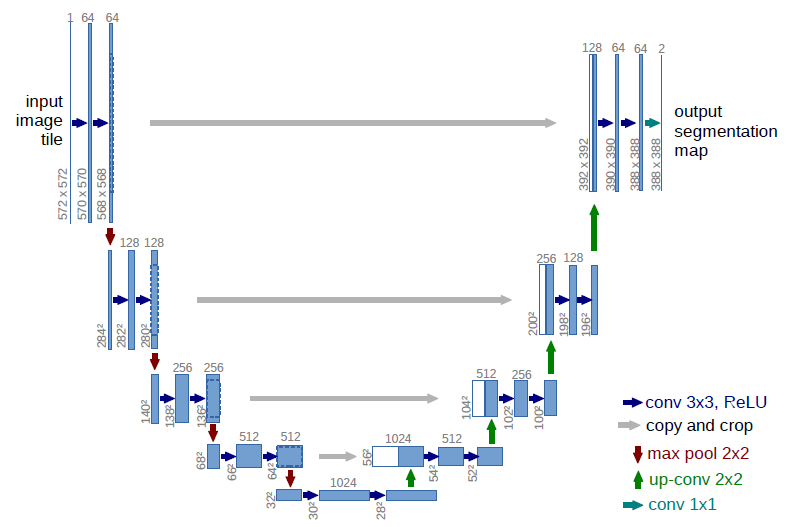

[Image reference](https://arxiv.org/abs/1505.04597)

## Imports

In [ ]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/segmentation.zip && unzip segmentation.zip

In [ ]:
!mv segmentation/* .

In [ ]:
# basic imports
import random
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting 
import cv2
import matplotlib.pyplot as plt

- We'll also import "segmentation_models_pytorch" which is a library ([accessible here](https://github.com/qubvel/segmentation_models.pytorch) where you can have direct access to models like UNet, DeepLab, etc...)
- It contains segmentation model weights trained with different encoder and dataset combinations
- Very Useful to setup custom model quickly for own problem statement via ***Transfer Learning***

In [ ]:
# try to import the library, if already present 
# good to go, else install it and then import library
try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

## 1. Dataset : Download and use BDD100k dataset

In [ ]:
# load images and label data
images = np.load("dataset/image_180_320.npy")
labels = np.load("dataset/label_180_320.npy")

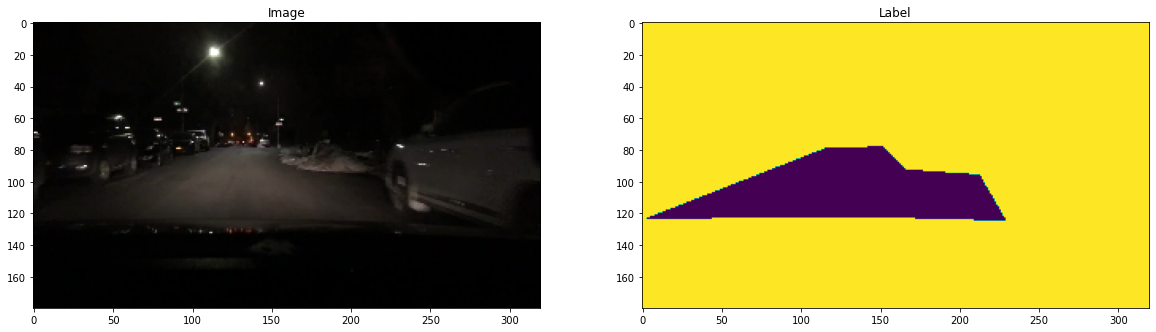

In [ ]:
# plot sample image
_, (ax0, ax1) = plt.subplots(1,2, figsize=(20,40))
ax0.imshow(images[458])    # random image number   
ax0.set_title("Image")
ax1.imshow(labels[458])
ax1.set_title("Label")
plt.show()

### Class label to standard color maps

- Often, its better to have standard color mappings for each class label.
- Helps in readability and consistency across different experimets. 
- [Cityscapes Dataset](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py) came up with a color mapping, which is pretty much standard across other datasets
- In our case, we'll define color mappings for the 3 classes - *Current lane, alternate lane and background*

In [ ]:
# Constants for Standard color mapping
# reference : https://github.com/bdd100k/bdd100k/blob/master/bdd100k/label/label.py
from collections import namedtuple

# Each label is a tuple with name, class id and color
Label = namedtuple( "Label", [ "name", "train_id", "color"])
drivables = [ 
             Label("direct", 0, (171, 44, 236)),        # red
             Label("alternative", 1, (86, 211, 19)),  # cyan
             Label("background", 2, (0, 0, 0)),        # black          
            ]

train_id_to_color = [c.color for c in drivables if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color = np.array(train_id_to_color)
print(f"train_id_to_color = \n {train_id_to_color}")

train_id_to_color = 
 [[171  44 236]
 [ 86 211  19]
 [  0   0   0]]


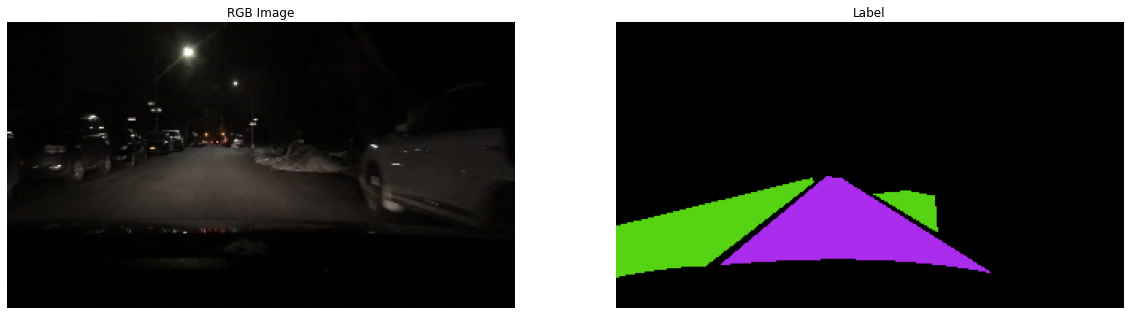

In [ ]:
# plot sample image using defined color mappings
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(images[458]);
axes[0].set_title("RGB Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[labels[201]]);
axes[1].set_title("Label");
axes[1].axis('off');

### Build Datasets & DataLoaders
Every PyTorch model is built and train using 3 elements:

*   Dataset
*   DataLoader
*   Model



#### Dataset Class

- We'll define a custom Pytorch Dataset class for BDD100k_dataset drivable / segmentation data. 
- The Dataset class should have at least `__len__()` and `__getitem__()` functions

In [ ]:
from torch.utils.data import Dataset, DataLoader

class BDD100k_dataset(Dataset):
    def __init__(self, images, labels, tf):
        self.images = images
        self.labels = labels
        self.tf = tf
    
    def __len__(self):
        return self.images.shape[0]
  
    def __getitem__(self, index):
        # read source image and convert to RGB, apply transform
        rgb_image = self.images[index]
        if self.tf is not None:
            rgb_image = self.tf(rgb_image)

        # read label image and convert to torch tensor
        label_image  = torch.from_numpy(self.labels[index]).long()
        return rgb_image, label_image

- Pytorch requires images in torch.Tensor format
- Also, need to normalize images to have zero mean pixel value and standard deviation of 1. **Helps in model learning faster and more robust**
- We'll use *reference mean and standard deviation from Imagenet dataset* in a **pytorch preprocessing transform**

In [ ]:
from torchvision import transforms
preprocess = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
                ])

In [ ]:
# Function to split data into train, validation and test sets
def get_datasets(images, labels):
    data = BDD100k_dataset(images, labels, tf=preprocess)
    total_count = len(data)
    train_count = int(0.7 * total_count) 
    valid_count = int(0.2 * total_count)
    test_count = total_count - train_count - valid_count
    train_set, val_set, test_set = torch.utils.data.random_split(data, 
                (train_count, valid_count, test_count), generator=torch.Generator().manual_seed(1))
    return train_set, val_set, test_set

#### Dataloaders

- Dataloaders help load data in batches
- We'll need to define separate dataloaders for training, validation and test sets



In [ ]:
def get_dataloaders(train_set, val_set, test_set):
    train_dataloader = DataLoader(train_set, batch_size=8,drop_last=True)
    val_dataloader   = DataLoader(val_set, batch_size=8)
    test_dataloader  = DataLoader(test_set, batch_size=8)
    return train_dataloader, val_dataloader, test_dataloader    


In [ ]:
train_set, val_set, test_set= get_datasets(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


### Show Sample images from dataset

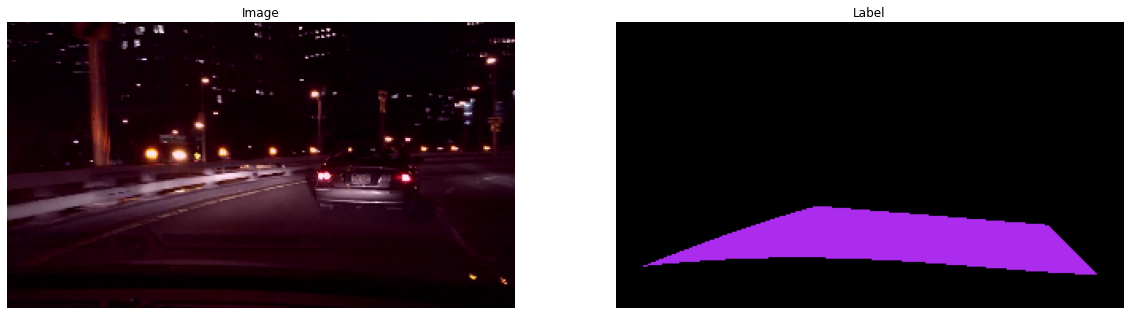

In [ ]:
from utils import inverse_transform

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

## 2. Network: Define a UNet Encoder-Decoder
Pay close attention to the image, this is what we are going to code:
![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Notice the 3 main elements:
* The Encoder
* The Decoder
* The Skip-Connections

### The Encoder
Notice how the encoder is made of these "double convolutions".
We have an input image, and then:

*   Two 3x3 Convolutions with ReLU
*   A 2x2 Max Pooling

That operation is repeated 4 times, as shown on the iPad.

**So let's implement this double convolutional block!** — Because this double convolution operation is repeated also later without Pooling, we'll leave pooling out and implement it later.

##### How to create a model with PyTorch 
With PyTorch, you always need to have a class with 2 elements:
* An __init__() function, where you define the convolutions, etc...
* A **forward()** function, where you define in which order the elements are going to be called.
<p>

See it like a salad; you first define your ingredients and get them out of the fridge (this is the Init function) and only then will you write a recipe with the elements you have (this is the forward function).

This is one element of the encoder, the other is pooling. So how does that work together?

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride =1, padding = 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride =1, padding = 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

In [ ]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, layer_channels):
        super(UNetEncoder, self).__init__()
        self.encoder = nn.ModuleList()

        # Double Convolution
        for num_channels in layer_channels:
            self.encoder.append(double_conv(in_channels, num_channels))
            in_channels = num_channels
        
        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self):
        # Pass input image through Encoder 
        for down in self.encoder:
            x = down(x)
            x = self.pool(x)
        return x

So, we have built the UNet Encoder; notice how we can now add a fully-connected layer and it would become a classification network!

But we're not gonna do that! Instead, we're going to implement a **Decoder**!
### The Decoder
The upsampling part is made through a series of 4:
* **One Transposed 2x2 Convolution**
* **A Double 3x3 Convolution with ReLU** (as in the encoder)

Finally, the model has **a final 1x1 convolution that classifies every single pixel**!

In [ ]:
import torchvision.transforms.functional as TF

class UNetDecoder(nn.Module):
    def __init__(self, layer_channels):
        super(UNetDecoder, self).__init__()
        self.decoder = nn.ModuleList()

        # Decoder layer Double Convolution blocks
        # and upsampling blocks
        self.decoder = nn.ModuleList()        
        for num_channels in reversed(layer_channels):
            # upsample output and reduce channels by 2
            self.decoder.append(nn.ConvTranspose2d(num_channels*2, num_channels, kernel_size=2, stride=2))
            self.decoder.append(double_conv(num_channels, num_channels))
        
    def forward(self, x):
        for up in self.decoder:
            x = up(x)
        return x

Alright! We have an Encoder-Decoder Architecture! But we ain't finished yet, we still to add those skip_connections!

### The Final UNet Architecture (with Skip-Connections)


In [ ]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels, layer_channels):
        super(UNetEncoder, self).__init__()
        self.encoder = nn.ModuleList()

        # Double Convolution blocks
        for num_channels in layer_channels:
            self.encoder.append(double_conv(in_channels, num_channels))
            in_channels = num_channels
        
        # Max Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        # Pass input image through Encoder blocks
        # and return outputs at each stage
        skip_connections = []
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        return x, skip_connections			
			
			
class UNetDecoder(nn.Module):
    def __init__(self, layer_channels):
        super(UNetDecoder, self).__init__()
        self.decoder = nn.ModuleList()

        # Decoder layer Double Convolution blocks
        # and upsampling blocks
        self.decoder = nn.ModuleList()        
        for num_channels in reversed(layer_channels):
            self.decoder.append(nn.ConvTranspose2d(num_channels*2, num_channels, kernel_size=2, stride=2))
            self.decoder.append(double_conv(num_channels*2, num_channels))
        
    
    def forward(self, x, skip_connections):
        for idx in range(0, len(self.decoder), 2):
            # upsample output and reduce channels by 2
            x = self.decoder[idx](x)
            
            # if skip connection shape doesn't match, resize
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            
            # concatenate and pass through double_conv block
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](concat_skip)
        return x		



class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, layer_channels):
        super(UNet, self).__init__()
        
        # Encoder and decoder modules
        self.encoder = UNetEncoder(in_channels, layer_channels)
        self.decoder = UNetDecoder(layer_channels)

        # conv layer to transition from encoder to decoder and 
        # 1x1 convolution to reduce num channels to out_channels
        self.bottleneck = double_conv(layer_channels[-1], layer_channels[-1]*2)
        self.final_conv = nn.Conv2d(layer_channels[0], out_channels, kernel_size=1)
        
        # initialize parameters now to avoid modifying the initialization of top_blocks
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                # nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder blocks
        encoder_output, skip_connections = self.encoder(x)

        # transition between encoder and decoder
        x = self.bottleneck(encoder_output)

        # we need the last skip connection first
        # so reversing the list 
        skip_connections = skip_connections[::-1]

        # Decoder blocks
        x = self.decoder(x, skip_connections)

        # final 1x1 conv to match input size
        return self.final_conv(x)          	

Nice work! Let's now train this model!

## 3. Training : Train and validate model on the custom dataset

In [ ]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

### Hyperparameters

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# reference : https://smp.readthedocs.io/en/latest/losses.html
criterion = smp.losses.DiceLoss('multiclass', classes=[0,1,2], log_loss = True, smooth=1.0)

# MODEL HYPERPARAMETERS
N_EPOCHS = 5
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'UNet_baseline'

# create model, optimizer, lr_scheduler and pass to training function
model = UNet(in_channels=3, out_channels=3, layer_channels=[64, 128, 256, 512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

### How to train a model with PyTorch

Here's the structure of a training loop in PyTorch:

**1) LOOP THROUGH THE DATALOADER N_EPOCH TIMES**
```python
    for epoch in range(num_epochs):        
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(dataloader_train, total=len_train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device) 
```
**2) FORWARD PASS**
```python
            # Forward pass
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
            train_loss += loss.item()
```
**3) BACKWARD PASS**
```python
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # adjust learning rate
            if lr_scheduler is not None:
                lr_scheduler.step()

```
**4) RUN ON THE TEST DATASET**
```python       
        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)
        validation_loss, validation_metric = evaluate_model(
                        model, dataloader_valid, criterion, metric_class, num_classes, device)
```
A note — We have another function call here, the evaluate_model() function is actually running its own forward pass, but on the dataset. You can find it on the **utils.py** file, section evaluate_model().<p>
**5) STORE & SHOW RESULTS**
```python
        results.append({'epoch': epoch, 
                        'trainLoss': train_loss, 
                        'validationLoss': validation_loss, 
                        f'{metric_name}': validation_metric})
        
        # if validation loss has decreased, save model and reset variable
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), f"{output_path}/{model_name}.pt")
            # torch.jit.save(torch.jit.script(model), f"{output_path}/{model_name}.pt")

    # plot results
    results = pd.DataFrame(results)
    plot_training_results(results, model_name)
    return results

```

You can find the entire training pipeline in the **utils.py** file — function **train_evaluate_model()**.

In [ ]:
output_path = "dataset"

In [ ]:
_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

Starting 1 epoch ...


  0%|          | 0/300 [00:06<?, ?it/s]


KeyboardInterrupt: ignored

# 4. Evaluate : Evaluate the model on Test Data and visualize results 

In [ ]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

100%|██████████| 43/43 [00:10<00:00,  3.95it/s]


Model has 0.6544332237440621 mean IoU in test set


In [ ]:
from utils import visualize_predictions

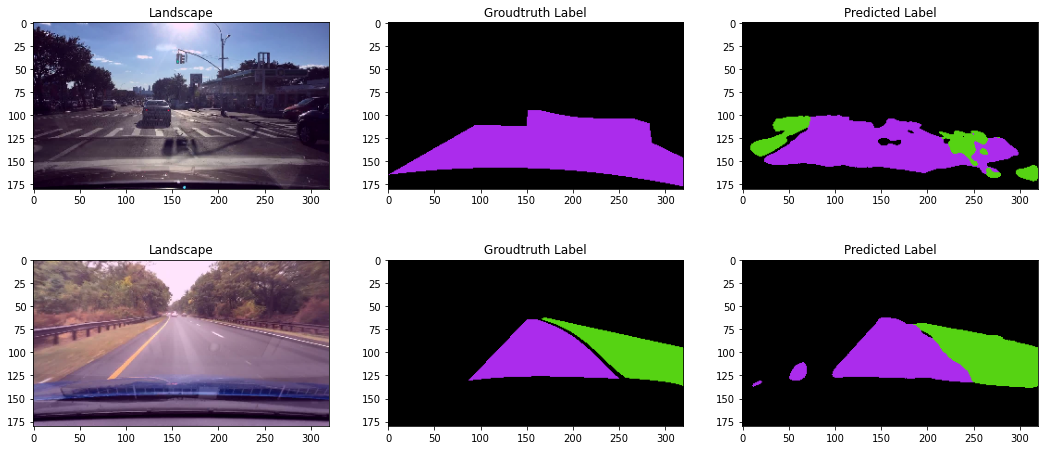

In [ ]:
num_test_samples = 2
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples, id_to_color=train_id_to_color)

## Test on sample video

In [ ]:
from utils import predict_video

In [ ]:
import os
from tqdm import tqdm
from utils import preprocess

def predict_cs_video(model, model_name, demo_video_path, id_to_color,
                     output_dir, target_width, target_height, device,
                    fps : int = 20, alpha : float = 0.3):
    
    test_images = [os.path.join(demo_video_path, *[x]) for x in sorted(os.listdir(demo_video_path))]
    
    output_filename = f'{model_name}_cs_part_overlay_demo_video.avi'
    output_video_path = os.path.join(output_dir, *[output_filename])

    # handles for input output videos
    output_handle = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'DIVX'), \
                                    20, (target_width, target_height))

    # create progress bar
    num_frames = int(len(test_images))
    pbar = tqdm(total = num_frames, position=0, leave=True)

    for i in range(num_frames):
        frame = cv2.imread(test_images[i])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # create torch tensor to give as input to model
        pt_image = preprocess(frame)
        pt_image = pt_image.to(device)

        # get model prediction and remap certain labels to showcase 
        # only certain colors. class index 19 has color map (0,0,0), 
        # so remap unwanted classes to 19
        y_pred = torch.argmax(model(pt_image.unsqueeze(0)), dim=1).squeeze(0)
        predicted_labels = y_pred.cpu().detach().numpy()
        predicted_labels[(predicted_labels < 11) & (predicted_labels != 0) & (predicted_labels != 6) & (predicted_labels != 7)] = 19
        
        # convert to corresponding color
        cm_labels = (id_to_color[predicted_labels]).astype(np.uint8)
        
        # overlay prediction over input frame
        overlay_image = cv2.addWeighted(frame, 1, cm_labels, alpha, 0)
        overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR)

        # write output result and update progress
        output_handle.write(overlay_image)
        pbar.update(1)

            
    output_handle.release()

In [ ]:
from IPython.display import HTML
HTML("""
    <video alt="test" controls>
        <source src="videos/project_video_360_640_UNet_baseline_output.avi" type="video/mp4">
    </video>
""")